In [2]:
import pandas as pd
import numpy as np
import io
import scipy as sp
import scipy.fftpack
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Load available DNS data from Moser's group

chanDNSReT = {
    "ReT_180" : 178.12,
    "ReT_395" : 392.24,
    "ReT_590" : 587.19,
    "ReT_1000" : 1000.512,
    "ReT_2000" : 1994.756,
    "ReT_5200" : 5185.897   
}

chanDNSMeans = {
    "ReT_180" : "../data/ReTau_180/processed/chan180_means.txt",
    "ReT_395" : "../data/ReTau_395/processed/chan395_means.txt",
    "ReT_590" : "../data/ReTau_590/processed/chan590_means.txt",
    "ReT_1000" : "../data/ReTau_1000/processed/chan1000_means.txt",
    "ReT_2000" : "../data/ReTau_2000/processed/chan2000_means.txt",
    "ReT_5200" : "../data/ReTau_5200/processed/chan5200_means.txt"    
}

chanDNSReys = {
    "ReT_180" : "../data/ReTau_180/processed/chan180_rey.txt",
    "ReT_395" : "../data/ReTau_395/processed/chan395_rey.txt",
    "ReT_590" : "../data/ReTau_590/processed/chan590_rey.txt",
    "ReT_1000" : "../data/ReTau_1000/processed/chan1000_rey.txt",
    "ReT_2000" : "../data/ReTau_2000/processed/chan2000_rey.txt",
    "ReT_5200" : "../data/ReTau_5200/processed/chan5200_rey.txt"    
}

chanDNSk = {
    "ReT_180" : "../data/ReTau_180/processed/chan180_k.txt",
    "ReT_395" : "../data/ReTau_395/processed/chan395_k.txt",
    "ReT_590" : "../data/ReTau_590/processed/chan590_k.txt",
    "ReT_1000" : "../data/ReTau_1000/processed/chan1000_k.txt",
    "ReT_2000" : "../data/ReTau_2000/processed/chan2000_k.txt",
    "ReT_5200" : "../data/ReTau_5200/processed/chan5200_k.txt"    
}


chanMeans = {}
chanReys = {}
chanK = {}

for key in chanDNSMeans:
    chanMeans[key] = pd.read_csv(chanDNSMeans[key], delim_whitespace=True)
    chanReys[key] = pd.read_csv(chanDNSReys[key], delim_whitespace=True)
    chanK[key] = pd.read_csv(chanDNSk[key], delim_whitespace=True)

## Pressure Driven Flow

The flow was driven with a constant pressure gradient: 

$\dfrac{\partial p}{\partial x}=\dfrac{- 2\rho u_{\tau}^2}{H}$

So in choosing a channel half height, $\delta$, of 1.0m, and a fluid density $\rho=1.0kg/m^3$ our constant pressure gradient is equal to $-1.0 kg/m^2s^2$.  

## $\Delta y_w$ Values For Channel Flow

For $Re_{\tau}$ of 395, 2000, and 18000, we want to choose $\Delta y$ near the wall that will resolve the turbulence as it inhabits a thinner and thinner layer near the wall with increasing $Re_{\tau}$. To do this, we only need two equations:

$ \Delta y_w^+ \equiv \dfrac{u^* \Delta y_w}{\nu} $

$ u^* = \sqrt{\nu \dfrac{\partial u}{\partial y}\bigg|_w}$

So for a $\Delta y_w^+ = 1$, given $u^* = 1$ (choosing $\nu$ to be $1/\tfrac{\partial u}{\partial y}\big|_w$), then the first grid cell $\Delta y_w$ is equal to the numerical value of $\nu$ or $1/Re_{\tau}$


## Mesh Sizes For Channel Flow

Channel size (following Gritskevitch) is H=2 in the y direction, and 4H in the x (streamwise) direction, and 1.5H in the z (spanwise) direction.

| $Re_{\tau}$   |  $Re_{\tau}$ DNS Actual  | $\Delta x$  | $n_x$ | $\Delta y$ | $n_y$ | $\Delta z$ | $n_z $ | $\Delta y_w$ at $\Delta y^+=1$ |
|---|---|---|---|---|---|---|---|
| 395  | 392.24  | 0.1 | 80 | Variable  | See below | 0.05 | 60 | 0.00253 |
| 2000 | 1994.756  | 0.1 | 80 | Variable  | See below | 0.05 | 60 | 0.0005 |
| 18000  | N/A  | 0.1 | 80 | Variable | See below | 0.05 | 60 | 5.556e-5  |

Note that the $n_y$ value is not noted in (Gritskevich, 2012) and instead the statement is made: "In the wall normal direction, different grids were used providing a sufficient resolution ($y_w^+ < 1$ near the wall) at different Reynolds numbers." Unfortunately this isn't much to go on...and in the previous sentence they say that WMLES was used for the two higher $Re_{\tau}$ cases. These statements seem contradictory?

Despite the lack of clarity in Gritskevich, two bases for choosing $n_y$ are:  1) the expansion ratio from the first grid cell does not exceed ~20%, and 2) that the center of the channel grid size is approximately equal to the turbulent length scale divided by some constant that represents the number of grid cells needed to represent an eddy (in the plot below I've chosen 8). For the given range of $Re_{\tau}$ this infers a maximum center channel grid size of ~$0.07m$, which is close to the (0.1,0.05) given in Gritskevich.

There are also some helpful guidelines here: https://wmles.umd.edu/hybrid-les-rans-models/hybrid-grid-requirements/

The same website shows differences when streamwise ($\Delta x / \Delta z$) AR is doubled https://wmles.umd.edu/validation/channel-flow-at-re5200/

Also intersting, OpenFOAM LES verification case: https://www.openfoam.com/documentation/guides/latest/doc/verification-validation-turbulent-plane-channel-flow.html


## Length Scale For Mesh Sizing

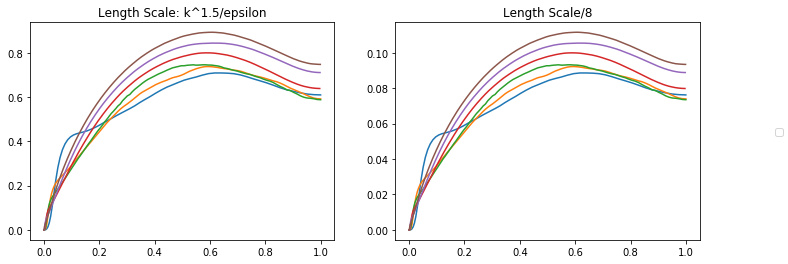

In [4]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(12,4))

for key in chanMeans:
    ax1.plot(chanReys[key]['y'],(chanReys[key]['k']**1.5)/(chanK[key]['dissip']*chanDNSReT[key]))
    ax1.set_title("Length Scale: k^1.5/epsilon")
    #ax1.set_xscale('log')
    
    #ax2.plot(chanReys[key]['y'],chanReys[key]['k']/(chanK[key]['dissip']*chanDNSReT[key]))
    #ax2.set_title("Time Scale: k/epsilon")
    #ax2.set_xscale('log')
    
    ax3.plot(chanReys[key]['y'],(chanReys[key]['k']**1.5)/(8*chanK[key]['dissip']*chanDNSReT[key]))
    ax3.set_title("Length Scale/8")
    #ax2.set_xscale('log')

handles, labels = ax3.get_legend_handles_labels()
labels = chanReys.keys()
fig.legend(handles, labels, loc='center right')

plt.show()

One remaining quesiton is how Gritskevich et al. came up with $\Delta x/\delta = 0.1$ and $\Delta z/\delta = 0.05$. The "Length Scale/8" plot should give a maximum-allowable mesh size at all points in the half-channel, given that 8 grid cells is enough to resolve an eddy. This also may suggest that Gritskevich's $\Delta x/\delta=0.1$ might be a tad high for these flows. 

## Estimate Minimum $n_y$ Given $\Delta y_w$ and Maximum Center Channel Size

In [22]:
# Max y-direction size (0.05 is 1:1 AR with delta z)
ymax = 0.05

# Channel half-height
chanHalf = 1.0

# Max growth rate
maxg = 0.3

# Initial Growth Rate
exr = 0.01
estep = -0.01
gr = np.arange(maxg,exr,step=estep)

# Testing ny
yn_init = 16
yn_add = 2
maxn=256
ny = np.arange(yn_init,maxn,step=yn_add)

# Turbulence Reynolds numbers
ret = [392.24, 1994.756, 18000.0]

ynfinal = {}
exrfinal = {}
lenfinal = {}
cwfinal = {}
gridfinal = {}

# Loop over ReTau
for r in ret:
    # First grid cell height
    dely = 1.0/r
    gridfinal[str(r)] = {}
    for g in gr: 
        for n in ny:
            temp = {}
            totlength = 0
            # Calculate cell heights
            for j in list(range(1,n+1)):
                if(j==1):
                    temp[str(j)] = dely
                if(j>1):
                    temp[str(j)] = temp[str(j-1)]*(1+g)
                totlength = totlength + temp[str(j)]

            lenDiff = chanHalf - totlength
            sizeDiff = ymax - temp[str(j)]
            if((abs(lenDiff)<0.05) and (abs(sizeDiff) < 0.005)):
                gridfinal[str(r)] = temp
                cwfinal[str(r)] = temp[str(j)]
                ynfinal[str(r)]= n*2
                exrfinal[str(r)] = 1+g
                lenfinal[str(r)] = totlength
                break

# Results
results = pd.DataFrame([exrfinal,ynfinal,lenfinal,cwfinal]).transpose()
results.columns = ["Growth Rate",r'$n_y$',r'$\delta$',"Channel Center Cell Size"]

In [23]:
results

,Growth Rate,$n_y$,$\delta$,Channel Center Cell Size
18000.0,1.05,280.0,1.027519,0.048982
1994.756,1.05,188.0,0.973836,0.046851
392.24,1.05,124.0,0.999072,0.050003


The table above shows the maximum growth rate and minimum $n_y$ to approximately reach a channel half width $\delta=1$ while maintaining the approximate cell size of 0.05m in the middle of the channel. 

[0.00254946 0.00267693 0.00281078 0.00295132 0.00309888 0.00325383
 0.00341652 0.00358735 0.00376671 0.00395505 0.0041528  0.00436044
 0.00457846 0.00480739 0.00504776 0.00530014 0.00556515 0.00584341
 0.00613558 0.00644236 0.00676448 0.0071027  0.00745783 0.00783073
 0.00822226 0.00863337 0.00906504 0.0095183  0.00999421 0.01049392
 0.01101862 0.01156955 0.01214803 0.01275543 0.0133932  0.01406286
 0.014766   0.0155043  0.01627952 0.01709349 0.01794817 0.01884557
 0.01978785 0.02077725 0.02181611 0.02290691 0.02405226 0.02525487
 0.02651762 0.0278435  0.02923567 0.03069746 0.03223233 0.03384394
 0.03553614 0.03731295 0.0391786  0.04113753 0.0431944  0.04535412
 0.04762183 0.05000292]


## RANS vs. LES Length Scales

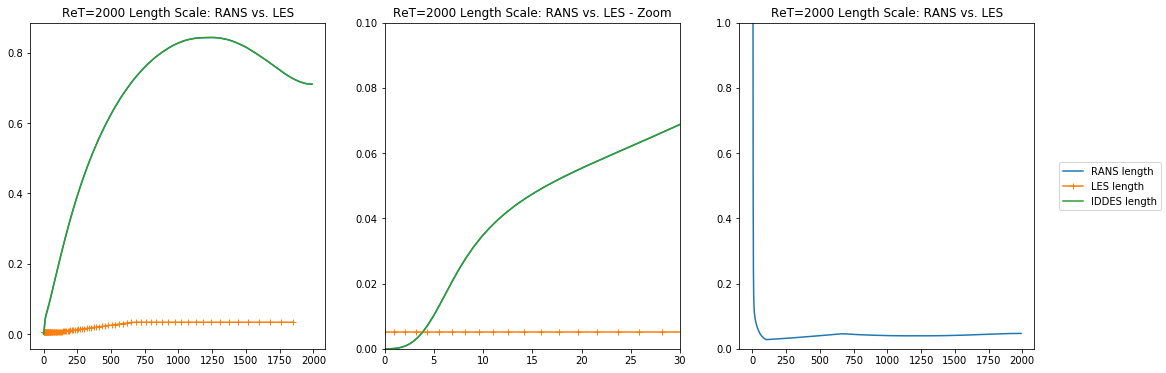

In [133]:
ret = "1994.756"
renu = 1/float(ret)

hmax = 0.05

dz = np.array(list(gridfinal[ret].values()))
dx = np.ones(len(dz))*hmax
dy = np.ones(len(dz))*0.05

dwall = np.ones(len(dz))

for idx, val in enumerate(dz):
    dwall[idx] = np.sum(dz[0:idx])

key = "ReT_2000"
lengthRANS = (chanReys[key]['k']**1.5)/(chanK[key]['dissip']*chanDNSReT[key])
lengthLES = 0.67*np.minimum(0.15*np.maximum(dwall,dx),dx)

alp = 0.25 - chanReys[key]['y']/hmax
fb = np.minimum(2*np.exp(-9*np.square(alp)),np.ones(len(chanReys[key]['y'])))
nut = 0.09*(chanReys[key]['k']**0.5)*lengthRANS
rdt = nut/(0.41*0.41*np.square(chanReys[key]['y'])*chanMeans[key]['dUmean/dy'])
fdt = 1.0-np.tanh(np.power(20*rdt,3))
fdtilda = np.maximum(1-fdt,fb)

lengthIDDES = fdtilda*lengthRANS + (1-fdtilda)*np.interp(chanReys[key]['y'],dwall,lengthLES)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

ax1.plot(chanReys[key]['y']/renu,lengthRANS,label="RANS length")
ax1.plot(dwall/renu,lengthLES,label="LES length",marker="+")
ax1.plot(chanReys[key]['y']/renu,lengthIDDES,label="IDDES length")
ax1.set_title("ReT=2000 Length Scale: RANS vs. LES")

ax2.plot(chanReys[key]['y']/renu,lengthRANS,label="RANS length")
ax2.plot(dwall/renu,lengthLES,label="LES length",marker="+")
ax2.plot(chanReys[key]['y']/renu,lengthIDDES,label="IDDES length")
ax2.set_title("ReT=2000 Length Scale: RANS vs. LES - Zoom")
ax2.set_xlim([0,30])
ax2.set_ylim([0,0.1])

ax3.plot(chanReys[key]['y']/renu,(np.interp(chanReys[key]['y'],dwall,lengthLES)/lengthIDDES),label="l_LES/l_IDDES")
ax3.set_title("ReT=2000 Length Scale: RANS vs. LES")
ax3.set_ylim([0,1])

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

plt.show()


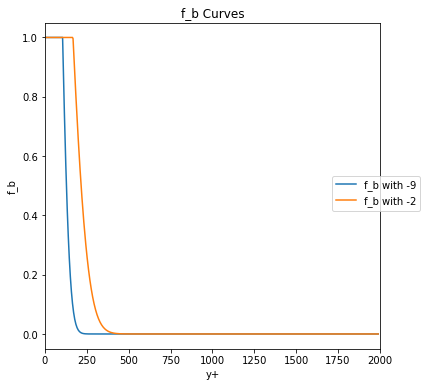

In [127]:
fborig = fb
fbnew = np.minimum(2*np.exp(-2*np.square(alp)),np.ones(len(chanReys[key]['y'])))

fig, (ax1) = plt.subplots(1,1,figsize=(6,6))

ax1.plot(chanReys[key]['y']/renu,fborig,label="f_b with -9")
ax1.plot(chanReys[key]['y']/renu,fbnew,label="f_b with -2")
ax1.set_title("f_b Curves")
ax1.set_xlim([0,2000])
ax1.set_ylabel("f_b")
ax1.set_xlabel("y+")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

plt.show()

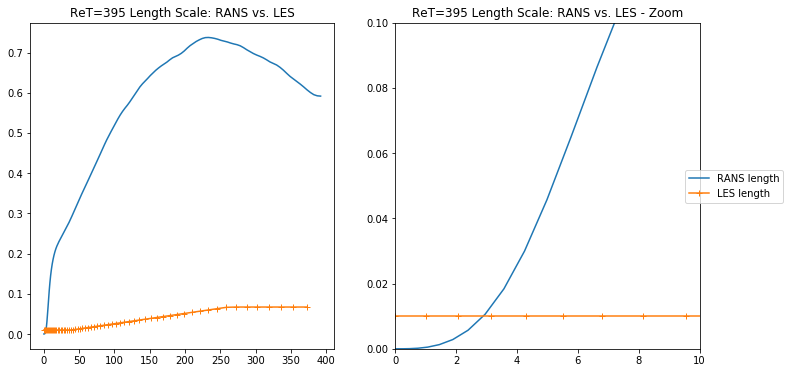

In [128]:
ret = "392.24"
renu = 1/float(ret)

dz = np.array(list(gridfinal[ret].values()))
dx = np.ones(len(dz))*0.1
dy = np.ones(len(dz))*0.05

dwall = np.ones(len(dz))

for idx, val in enumerate(dz):
    dwall[idx] = np.sum(dz[0:idx])

key = "ReT_395"

lengthRANS = (chanReys[key]['k']**1.5)/(chanK[key]['dissip']*chanDNSReT[key])
lengthLES = 0.67*np.minimum(0.15*np.maximum(dwall,dx),dx)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.plot(chanReys[key]['y']/renu,lengthRANS,label="RANS length")
ax1.plot(dwall/renu,lengthLES,label="LES length",marker="+")
ax1.set_title("ReT=395 Length Scale: RANS vs. LES")

ax2.plot(chanReys[key]['y']/renu,lengthRANS,label="RANS length")
ax2.plot(dwall/renu,lengthLES,label="LES length",marker="+")
ax2.set_title("ReT=395 Length Scale: RANS vs. LES - Zoom")
ax2.set_xlim([0,10])
ax2.set_ylim([0,0.1])

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

plt.show()